#Reproduce plots from Figure 4
Stimulation dataset \
Plot: Example stim and recording \

note: recording data is preprocessed (bandpass filtering, whitening, artifact removal)


In [3]:
%run importrhsutilities.py
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw

from probeinterface import Probe, ProbeGroup
from probeinterface import generate_linear_probe, generate_multi_shank
from probeinterface import combine_probes
from probeinterface.plotting import plot_probe

import datetime
from uuid import uuid4

import numpy as np
from dateutil.tz import tzlocal

from pynwb import NWBHDF5IO, NWBFile
from pynwb.ecephys import LFP, ElectricalSeries
from pprint import pprint

import matplotlib.pyplot as plt

/home/laurendiaz/miniconda3/envs/oipls/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/laurendiaz/miniconda3/envs/oipls/lib/python3.10/site-packages/tridesclous/numba_tools.py:11: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True)
/home/laurendiaz/miniconda3/envs/oipls/lib/python3.10/site-packages/tridesclous/numba_tools.py:33: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argum

In [1]:
def pull_files(recording_name,fpath='/media/t7/surpass/electrophysiology/Gracias Data/Organoid_Batch14/'):
    '''
    input:
    day - int - day number
    recording_name - string - string name of recording folder
    '''
    filepath = fpath + recording_name + '/*.rhs'
    fnames = glob.glob(filepath)
    results = 0
    for i in np.arange(len(fnames)):
        res, data_present = load_file(fnames[i])
        if i == 0:
            results = [res]
        else:
            results.append(res)
    return results

def all_intan_data(channel_names, signal_data_name,results):
    dfs = []
    i = 0
    for res in results:
        #save times for later processing
        dict_data = {}
        dict_data['time'] = res['t']

        #add data for each channel to master df
        j = 0
        for chan in channel_names:
            channel_found, signal_type, signal_index = find_channel_in_header(chan, res)
            dict_data[chan] = res[signal_data_name][signal_index,:]/1000 # data is in mV but NWB electrical series type expects V
            j += 1
        df = pd.DataFrame.from_dict(dict_data)
        dfs.append(df)
        i+=1
    rec_data = pd.concat([dfs[i] for i in range(len(dfs))], axis=0)
    rec_data = rec_data.set_index('time')
    return rec_data

def gen_probe():
    north = generate_linear_probe(num_elec=1)
    north.rotate(180)
    north.set_contacts(positions=[[0,75]])


    east = generate_linear_probe(num_elec=1)
    east.rotate(90)
    east.set_contacts(positions=[[75,0]])

    west = generate_linear_probe(num_elec=1)
    west.rotate(-90)
    west.set_contacts(positions=[[-75,0]])

    multi_shank = combine_probes([west, east, north])
    plot_probe(multi_shank, with_channel_index=True)
    plt.show()
    multi_shank.set_device_channel_indices([0,1,2])
    return multi_shank

def preprocessing(rec_name):
    recording = se.read_nwb_recording(rec_name,electrical_series_name="ES")
    multi_shank = gen_probe()
    recording = recording.set_probe(multi_shank)
    #preprocessing: bandpass filtering
    recording_cmr = recording
    recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=3000)
    print(recording_f)
    recording_cmr = spre.common_reference(recording_f, reference='global', operator='median')
    print(recording_cmr)

    #this computes and saves the recording after applying the preprocessing chain
    recording_preprocessed = recording_cmr.save(format='binary')
    print(recording_preprocessed)
    return recording, recording_preprocessed

# BO2 11/17 20 uA (Organoid Batch 14 Set)

In [7]:
fpath = '../data'

## Representative Wave of Stimulation

In [8]:
stim_recording = se.read_nwb_recording(fpath+'/NWBFiles/BO2W1Stim_111723_20uA233uS.nwb',electrical_series_name="ES_STIM")

In [11]:
times = stim_recording.get_times()
times

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       9.11956333e+01, 9.11956667e+01, 9.11957000e+01])

Text(0.5, 0.98, '           Stimulation 20 uA BO2 11/17/23')

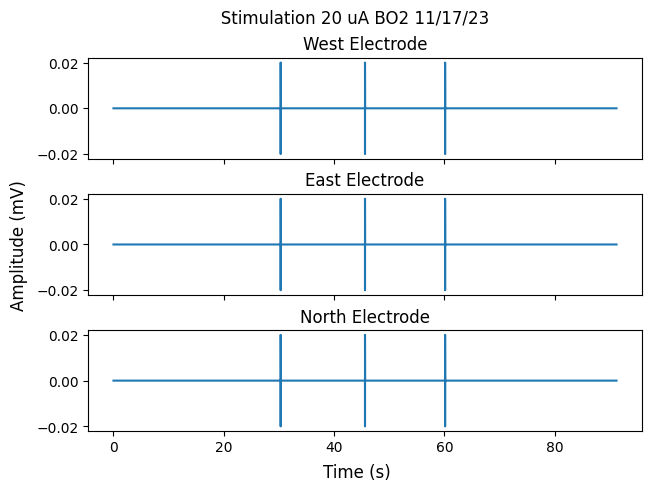

In [13]:
fig, ax = plt.subplots(3, 1, layout='constrained', sharex=True, sharey=True)
ax[0].plot(times, stim_recording.get_traces()[:,0])
ax[0].set_title('West Electrode')
ax[1].plot(times, stim_recording.get_traces()[:,1])
ax[1].set_title('East Electrode')
ax[2].plot(times, stim_recording.get_traces()[:,2])
ax[2].set_title('North Electrode')
fig.supxlabel('            Time (s)')
fig.supylabel('Amplitude (mV)')
fig.suptitle('           Stimulation 20 uA BO2 11/17/23')

## Representative Plot of Recording

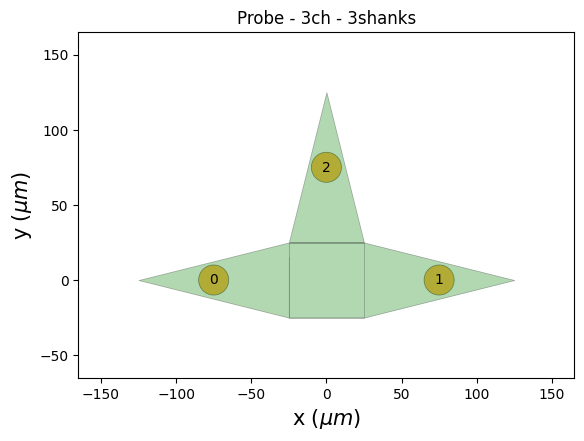

BandpassFilterRecording: 3 channels - 1 segments - 30.0kHz - 91.196s
CommonReferenceRecording: 3 channels - 1 segments - 30.0kHz - 91.196s
Use cache_folder=/tmp/spikeinterface_cache/tmpjyyp0m2q/JEYD078X
write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording: 100%|##########| 92/92 [00:00<00:00, 351.86it/s]

BinaryFolderRecording: 3 channels - 1 segments - 30.0kHz - 91.196s


In [19]:
recording, _ = preprocessing(fpath+'/NWBFiles/BO2W1Stim_111723_20uA233uS.nwb')
multi_shank = gen_probe()
multirecording = recording.set_probe(multi_shank)

# Make sure the recording is preprocessed appropriately
# lazy preprocessing
multirecording_filtered = spre.bandpass_filter(multirecording, freq_min=300, freq_max=6000)
multirecording: si.BaseRecording = spre.whiten(multirecording_filtered, dtype='float32')
channel = multirecording.get_traces()[:,0]

In [22]:
stimulation_trigger_frames = np.where(np.abs(channel)>7.5)
recording_rmartifact = spre.remove_artifacts(multirecording,
                                                         list_triggers=stimulation_trigger_frames[0].tolist(),
                                                         ms_before=10, ms_after=10)

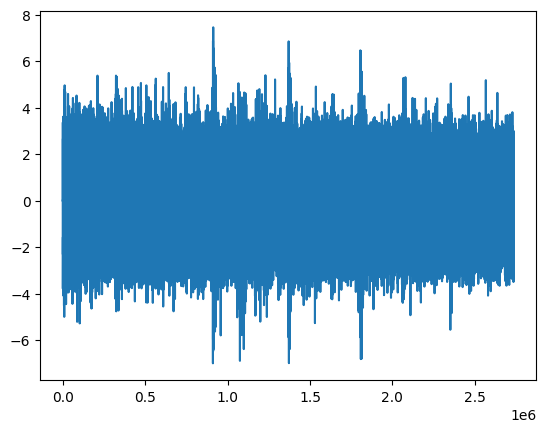

In [24]:
channel = recording_rmartifact.get_traces()[:,0]
plt.plot(channel)
multirecording = recording_rmartifact

In [43]:
times = multirecording.get_times()
times

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       9.11956333e+01, 9.11956667e+01, 9.11957000e+01])

Text(0.5, 0.98, '           Recording BO2 11/17/23')

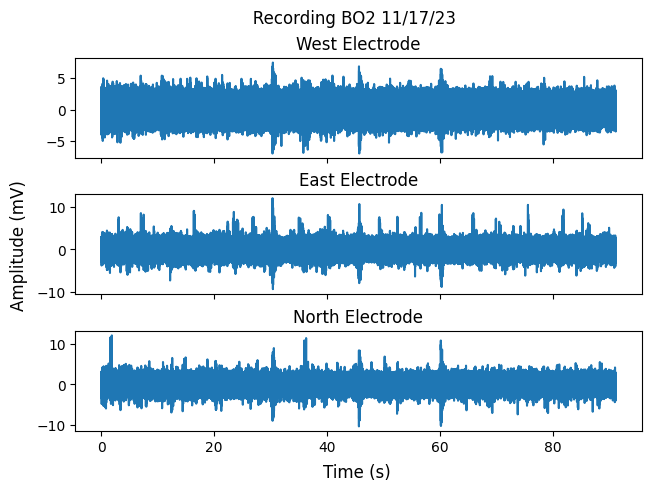

In [88]:
times = multirecording.get_times()
fig, ax = plt.subplots(3, 1, layout='constrained', sharex=True)
ax[0].plot(times, multirecording.get_traces()[:,0])
ax[0].set_title('West Electrode')
ax[1].plot(times, multirecording.get_traces()[:,1])
ax[1].set_title('East Electrode')
ax[2].plot(times, multirecording.get_traces()[:,2])
ax[2].set_title('North Electrode')
fig.supxlabel('            Time (s)')
fig.supylabel('Amplitude (mV)')
fig.suptitle('           Recording BO2 11/17/23')
